# Simple code
First make sure that you install requirements:

`!pip install -r requirements.txt`

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder # this function is used to prepare one-hot encoded labels

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,3) # set default size of plots

data_dir = os.path.join(os.path.expanduser('~'),'Documents','Data')
save_dir = os.path.join(os.path.expanduser('~'),'Documents','Data','Simulations')
device = 'cpu'

Files already downloaded and verified
Files already downloaded and verified


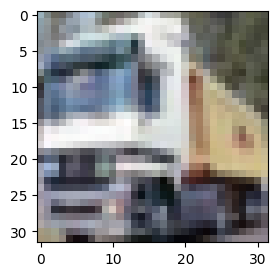

True
torch.Size([3, 32, 32])


In [2]:
# CIFAR10 Dataset
original_train_dataset = datasets.CIFAR10(root=data_dir, train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.CIFAR10(root=data_dir, train=False, transform=transforms.ToTensor(), download=True)

plt.imshow(original_train_dataset.data[1]) # represnting a sample data from CIFAR-10
plt.show()

print(torch.is_tensor(original_train_dataset[1][0]))  # This will print True if the data is indeed a PyTorch tensor
print(original_train_dataset[1][0].shape)

In [6]:
x_train = np.array(original_train_dataset.data,dtype='float32')
x_test = np.array(original_test_dataset.data,dtype='float32')


x_test = torch.tensor(x_test)
x_test = x_test.permute(0,3,1,2)
x_test.to(device)


# Reshape y_train and y_test to 2D arrays
y_train = np.array(original_train_dataset.targets)
y_test = np.array(original_test_dataset.targets)

y_test = torch.tensor(y_test)
y_test.to(device)

In [4]:
def make_batches(x, y, batch_size):
    n = len(y)
    steps = n // batch_size
    if n % batch_size != 0:
        steps += 1
    x_batches = np.array_split(x,steps)
    y_batches = np.array_split(y,steps)
    return x_batches, y_batches

In [9]:
class MyCNN(nn.Module):
    def __init__(self,device):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding='same')
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding='same')
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding='same')
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same')
        
        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64*8*8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        for name, param in self.named_parameters():
            print(name, param.shape)
            if name == "conv1.weight" or name == "conv2.weight" or name == "conv3.weight" or name == "conv4.weight" or name == "conv5.weight" or name == "fc1.weight" or name == "fc2.weight" or name == "fc3.weight":
                nn.init.normal_(param,std=0.05)
            if name == "conv1.bias" or name == "conv2.bias" or name == "conv3.bias" or name == "conv4.bias" or name == "conv5.bias" or name == "fc1.bias" or name == "fc2.bias" or name == "fc3.bias":
                nn.init.zeros_(param)
        self.to(device)


    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.maxpool(x)
        x = self.relu(self.conv5(x))
        
        # Flatten the output for fully connected layers
        x = x.view(-1, 64*8*8)
        
        # Fully connected layers with ReLU activation
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        
        # Output layer with softmax activation
        #x = self.softmax(self.fc3(x))
        return x
model = MyCNN(device)

conv1.weight torch.Size([16, 3, 5, 5])
conv1.bias torch.Size([16])
conv2.weight torch.Size([16, 16, 5, 5])
conv2.bias torch.Size([16])
conv3.weight torch.Size([32, 16, 5, 5])
conv3.bias torch.Size([32])
conv4.weight torch.Size([32, 32, 5, 5])
conv4.bias torch.Size([32])
conv5.weight torch.Size([64, 32, 5, 5])
conv5.bias torch.Size([64])
fc1.weight torch.Size([128, 4096])
fc1.bias torch.Size([128])
fc2.weight torch.Size([128, 128])
fc2.bias torch.Size([128])
fc3.weight torch.Size([10, 128])
fc3.bias torch.Size([10])


In [17]:
lr = 1e-4

opt = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

batch_size = 256
x_train_batches, y_train_batches = make_batches(x_train, y_train, batch_size)

In [18]:
N_EPOCH = 100

In [19]:
loss = []
for epoch in range(N_EPOCH):
    for i in range(len(x_train_batches)):
        x = torch.tensor(x_train_batches[i])
        y = torch.tensor(y_train_batches[i])

        x = x.permute(0,3,1,2)

        x.to(device)
        y.to(device)

        y_pred = model(x)

        opt.zero_grad()
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()

        # test
        # zero gradients
        # TODO
        if i % 10 == 0:
            y_test_pred = model(x_test)
            test_loss = criterion(y_test_pred, y_test)
            loss.append(test_loss.item())
    
    print("epoch: {} \t last batch loss: {} \t last batch loss: {}".format(epoch, loss.item(),test_loss.item()))

epoch: 0 	 last batch loss: 1.8863343000411987
epoch: 1 	 last batch loss: 1.6850991249084473
epoch: 2 	 last batch loss: 1.5256953239440918
epoch: 3 	 last batch loss: 1.4202570915222168
epoch: 4 	 last batch loss: 1.3495240211486816
epoch: 5 	 last batch loss: 1.2969039678573608
epoch: 6 	 last batch loss: 1.2422821521759033
epoch: 7 	 last batch loss: 1.181040644645691
epoch: 8 	 last batch loss: 1.1344681978225708
epoch: 9 	 last batch loss: 1.0838072299957275
epoch: 10 	 last batch loss: 1.0469635725021362
epoch: 11 	 last batch loss: 1.0168917179107666
epoch: 12 	 last batch loss: 0.974344789981842
epoch: 13 	 last batch loss: 0.932620644569397
epoch: 14 	 last batch loss: 0.8892673254013062
epoch: 15 	 last batch loss: 0.8581683039665222
epoch: 16 	 last batch loss: 0.827208399772644
epoch: 17 	 last batch loss: 0.7967416048049927
epoch: 18 	 last batch loss: 0.780257523059845
epoch: 19 	 last batch loss: 0.7680070400238037
epoch: 20 	 last batch loss: 0.7337794899940491
epoch: 